In [1]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import torch.optim as optim
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader

from visualization import add_bbox, plot_examples, plot_predictions, part_info
from datasets import HaloDataset
from assigners import TAL_assigner_batch
from losses import FocalLoss, DistanceIoULoss, ComputeLoss
from model import Detector
from train import Runner
from test import predict, validate
from filters import filter_prediction_nms

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


# Загрузка и обзор датасета

https://huggingface.co/datasets/Francesco/halo-infinite-angel-videogame/tree/main/data

In [5]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Датасет собран в таблицу, в которой содержатся следующие столбцы: id изображения, само изображение в байтах, ширина и высота изображения, описание объектов.

In [ ]:
df_train.head()

image_id                                              image  width  height  \
0       311  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
1        67  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
2       161  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
3       210  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
4       142  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   

                                             objects  
0  {'id': [573, 574], 'area': [1748, 15756], 'bbo...  
1  {'id': [137, 138], 'area': [14136, 88392], 'bb...  
2  {'id': [301, 302], 'area': [3016, 33768], 'bbo...  
3  {'id': [379, 380], 'area': [832, 9248], 'bbox'...  
4  {'id': [272, 273], 'area': [1520, 16704], 'bbo...

Описание объектов: id - список с id всех объектов на изображении, area - площади объектов в пикселях, bbox - ограничивающие рамки оъектов в формате COCO (x, y верхнего левого угла и w - ширина и y - высота), категории (метки) объектов.

In [ ]:
pd.json_normalize(df_train['objects'])

id                      area  \
0              [573, 574]             [1748, 15756]   
1              [137, 138]            [14136, 88392]   
2              [301, 302]             [3016, 33768]   
3              [379, 380]               [832, 9248]   
4              [272, 273]             [1520, 16704]   
..                    ...                       ...   
457                  [33]                    [6160]   
458  [356, 357, 358, 359]  [3472, 784, 5452, 52592]   
459            [783, 784]             [6160, 65520]   
460            [381, 382]             [2700, 43152]   
461                 [755]                    [9984]   

                                                  bbox      category  
0    [[248.0, 228.0, 38.0, 46.0], [232.0, 228.0, 78...        [2, 1]  
1    [[520.0, 278.0, 114.0, 124.0], [386.0, 270.0, ...        [2, 1]  
2    [[340.0, 48.0, 52.0, 58.0], [298.0, 48.0, 126....        [2, 1]  
3    [[310.0, 272.0, 26.0, 32.0], [286.0, 272.0, 68...        [2, 1]  
4    [[304.0, 300.0, 40.0, 38.0], [276.0, 300.0, 96...        [2, 1]  
..                                                 ...           ...  
457                      [[312.0, 318.0, 44.0, 140.0]]           [1]  
458  [[396.0, 224.0, 62.0, 56.0], [578.0, 304.0, 28...  [4, 2, 1, 3]  
459  [[266.0, 156.0, 70.0, 88.0], [206.0, 176.0, 18...        [2, 1]  
460  [[372.0, 302.0, 50.0, 54.0], [260.0, 304.0, 18...        [2, 1]  
461                      [[320.0, 352.0, 96.0, 104.0]]           [1]  

[462 rows x 4 columns]

Необходимые столбцы из датасета:

In [ ]:
d = pd.concat([df_train[["image_id"]],pd.json_normalize(df_train['objects'])[["bbox","category"]],pd.json_normalize(df_train['image'])[["bytes"]]], axis = 1)
d

image_id                                               bbox  \
0         311  [[248.0, 228.0, 38.0, 46.0], [232.0, 228.0, 78...   
1          67  [[520.0, 278.0, 114.0, 124.0], [386.0, 270.0, ...   
2         161  [[340.0, 48.0, 52.0, 58.0], [298.0, 48.0, 126....   
3         210  [[310.0, 272.0, 26.0, 32.0], [286.0, 272.0, 68...   
4         142  [[304.0, 300.0, 40.0, 38.0], [276.0, 300.0, 96...   
..        ...                                                ...   
457        17                      [[312.0, 318.0, 44.0, 140.0]]   
458       193  [[396.0, 224.0, 62.0, 56.0], [578.0, 304.0, 28...   
459       428  [[266.0, 156.0, 70.0, 88.0], [206.0, 176.0, 18...   
460       211  [[372.0, 302.0, 50.0, 54.0], [260.0, 304.0, 18...   
461       410                      [[320.0, 352.0, 96.0, 104.0]]   

         category                                              bytes  
0          [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
1          [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
2          [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
3          [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
4          [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
..            ...                                                ...  
457           [1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
458  [4, 2, 1, 3]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
459        [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
460        [2, 1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
461           [1]  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  

[462 rows x 4 columns]

Всего 4 класса: враг, голова врага, друг, голова друга.

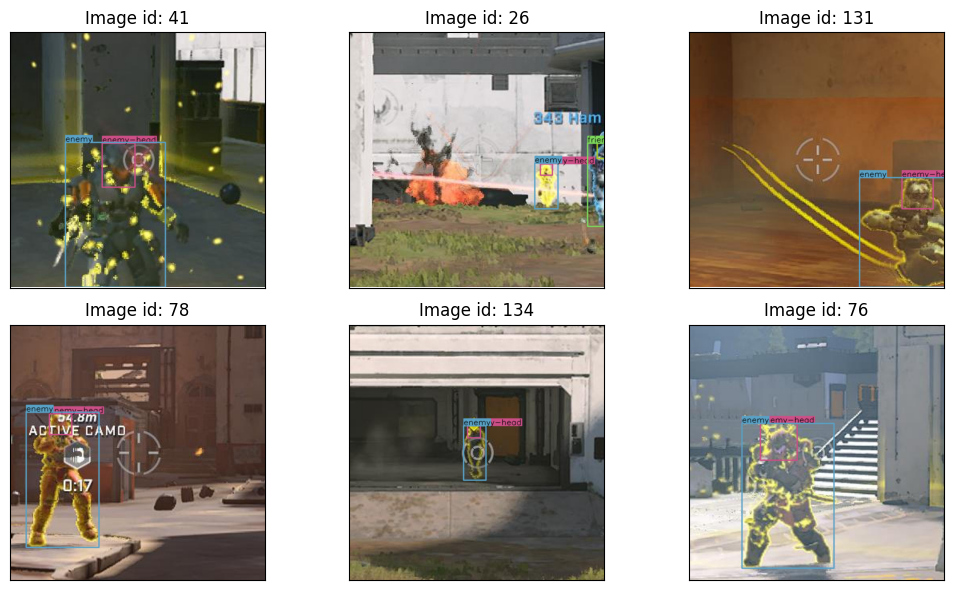

In [6]:
plot_examples(df_test)

Статистики по датасету

Min bboxes per image: 0
Max bboxes per image: 6
Mean bboxes per image: 1.84


Number of object per class:
enemy-head : 331
enemy : 387
friendly-head : 37
friendly : 93

Mean bbox size per class:
enemy : [117.48837 205.58656]
enemy-head : [46.95468  49.123867]
friendly : [113.91398 213.46237]
friendly-head : [61.45946 57.62162]





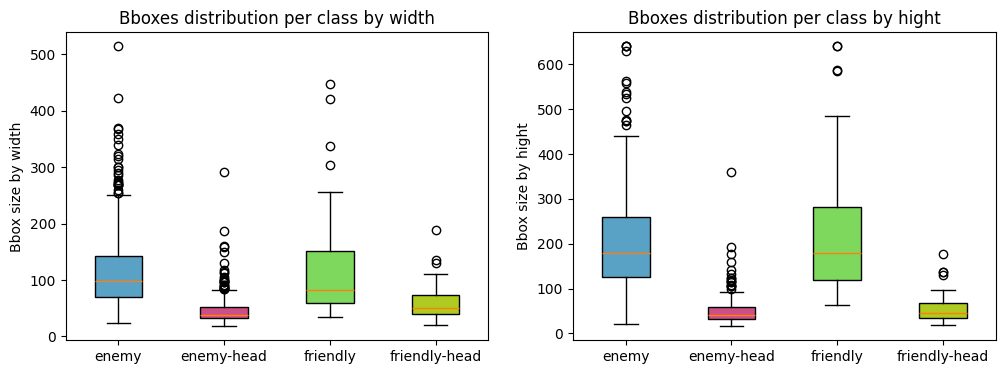

In [ ]:
box_sizes = part_info(df_train)

Создадим датасеты для тренировочных и валидационных данных.

Augmentation:

In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transforms = A.Compose(
    [
        A.Normalize(mean, std),
        A.HorizontalFlip(0.5),
        A.Rotate(limit=15),
        A.RandomBrightnessContrast(0.2),
        A.Affine(p=0.5, scale=0.8, shear=10, translate_percent=0.1, rotate=15),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

test_transforms = A.Compose(
    [
        A.Normalize(mean, std),
        ToTensorV2()
    ]
)

In [8]:
train_dataset = HaloDataset(df_train, mode="train", transform=train_transforms)
valid_dataset = HaloDataset(df_validation, mode="validation", transform=test_transforms)

# Процесс обучения

In [9]:
def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

Запустим обучение на 30 эпох. В качестве регрессионного лосса используем DIoU loss, а в качестве confidence loss используем Focal loss.

In [15]:
lr = 1e-3
NUM_EPOCHS = 30
model = Detector().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=5e-5)
compute_loss = ComputeLoss(bbox_loss=DistanceIoULoss(), obj_loss=FocalLoss())
runner = Runner(model, train_dataloader, compute_loss, optimizer, device=DEVICE,
                 scheduler=scheduler, val_dataloader=val_dataloader, val_freq=5)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [16]:
torch.autograd.set_detect_anomaly(True)
runner.train(num_epochs=NUM_EPOCHS, verbose=True)

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
runner.epoch_loss

[np.float64(4.804672931802684),
 np.float64(3.491090774536133),
 np.float64(2.9569489462622283),
 np.float64(2.6130722473407615),
 np.float64(2.472111395720778),
 np.float64(2.308893117411383),
 np.float64(2.1875242220944373),
 np.float64(2.110165972134163),
 np.float64(2.027194853486686),
 np.float64(1.964953328001088),
 np.float64(1.913142154956686),
 np.float64(1.8653001620851715),
 np.float64(1.835242626995876),
 np.float64(1.788481383488096),
 np.float64(1.7209272035237015),
 np.float64(1.7227762423712631),
 np.float64(1.6943188124689563),
 np.float64(1.6940580811993828),
 np.float64(1.6363796797291985),
 np.float64(1.5999174488001857),
 np.float64(1.6153253974585697),
 np.float64(1.5915895207174893),
 np.float64(1.5653268735984276),
 np.float64(1.5272646772450413),
 np.float64(1.5294392026703933),
 np.float64(1.507584824644286),
 np.float64(1.5044164513719493),
 np.float64(1.4850684671566403),
 np.float64(1.4575652254038844),
 np.float64(1.485995455034848)]

In [18]:
runner.val_metric

[0.09186694025993347,
 0.17300643026828766,
 0.18130894005298615,
 0.21522335708141327,
 0.2379707247018814,
 0.2635453939437866]

Посмотрим на кривые обучения: лосс по батчам и эпохам, mAP по эпохам.

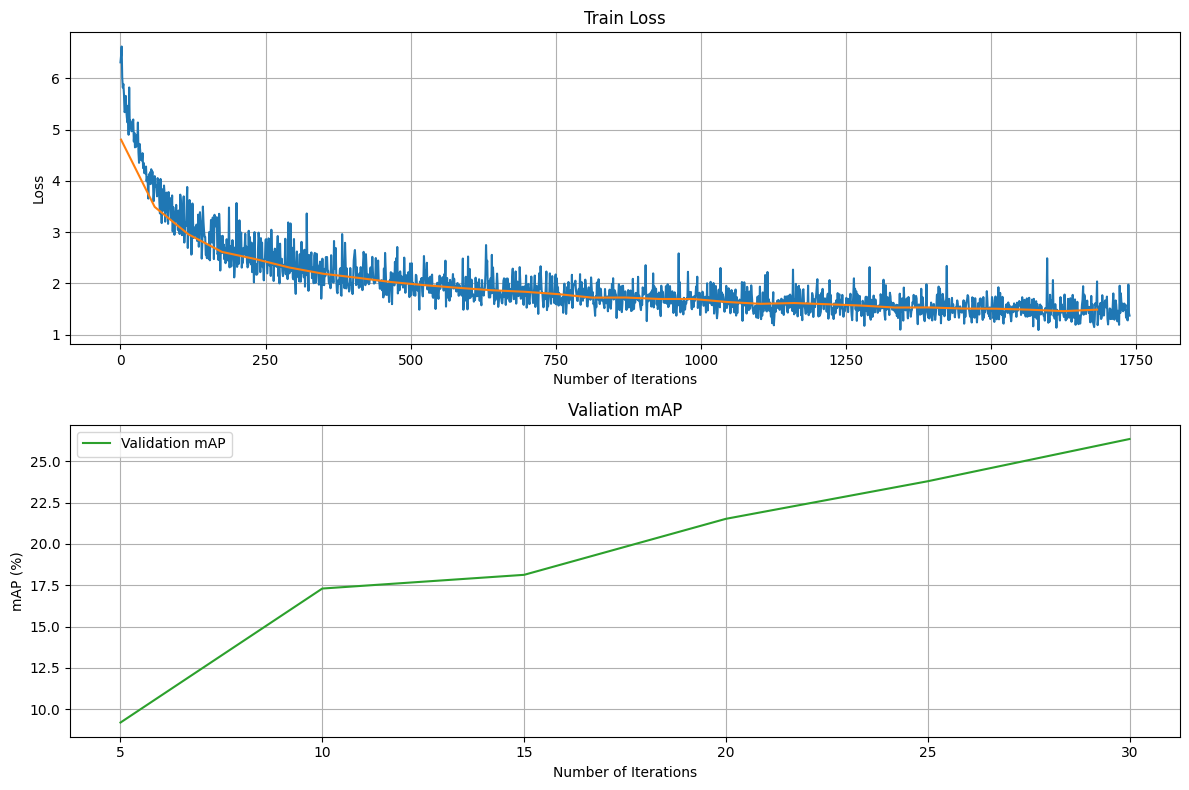

In [19]:
runner.plot_loss(row_figsize=4)

Сохраним модель

In [24]:
from pathlib import Path

In [25]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [26]:
BASE_DIR = Path('/content/gdrive/MyDrive/')

In [27]:
torch.save({
        'epoch': 30,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, f'{BASE_DIR}/detection_model_30_ep_v1.pt')

In [ ]:
# Загрузка сохраненной модели
#model = Detector().to(DEVICE)
#checkpoints = torch.load(Path('/content/gdrive/MyDrive/detection_model_30_ep_v1.pt'), map_location=DEVICE)
#model.load_state_dict(checkpoints['model_state_dict'])
#model.eval()

# Предсказания

Визуализация предсказаний на валидационной выборке.

In [20]:
val_iter = iter(val_dataloader)

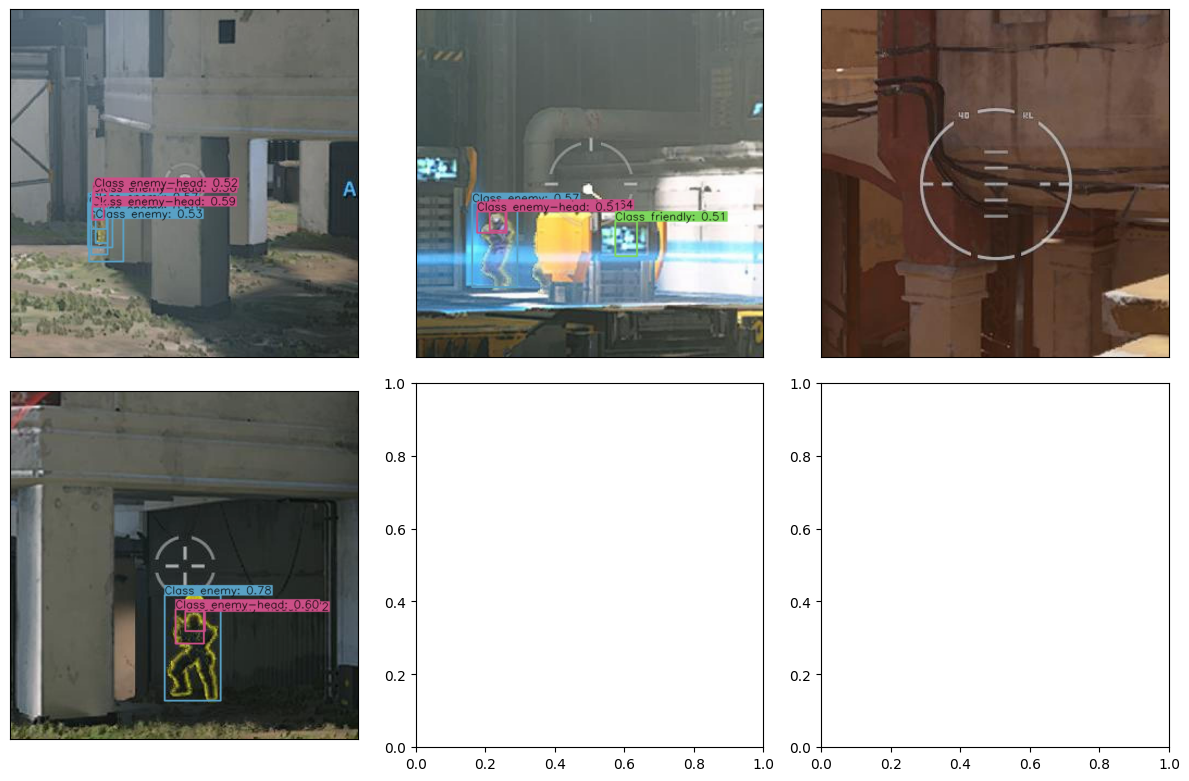

In [23]:
images, target = next(val_iter)
preds = predict(model, images, device=DEVICE, score_threshold=0.5, iou_threshold=0.5)
plot_predictions(images, preds)

Визуализация предсказаний на тестовой выборке.

In [28]:
test_dataset = HaloDataset(df_test, mode="test", transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False)

In [29]:
test_iter = iter(test_dataloader)

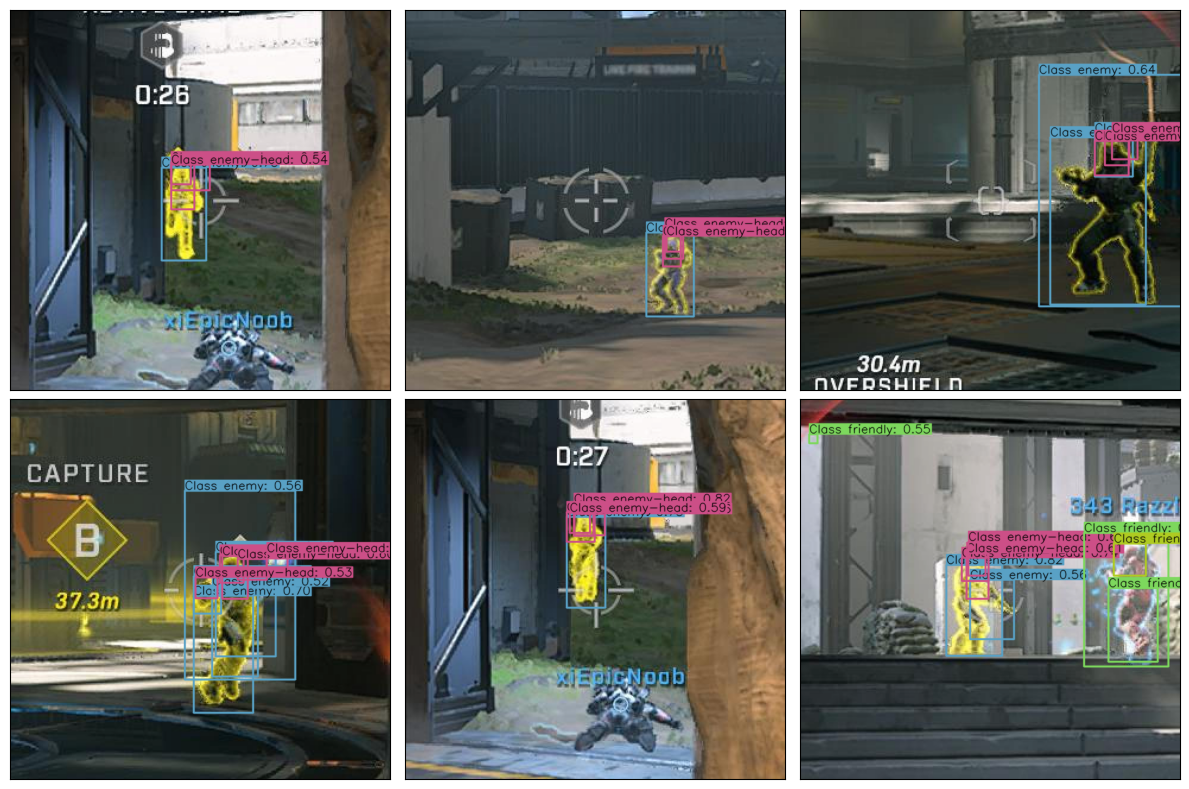

In [31]:
images = next(test_iter)
preds = predict(model, images, device=DEVICE, score_threshold=0.5, iou_threshold=0.5)
plot_predictions(images, preds)

Видно, что объекты детектируются, но присутствует много лишних рамок. Также уверенность предсказаний еще не досаточно высокая, но уже более 50%.

Получим mAp на тестовой выборке.

In [32]:
test_dataset = HaloDataset(df_test, mode="validation", transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, collate_fn=collate_fn)

In [39]:
val_metric, res = validate(model, test_dataloader, device=DEVICE, score_threshold=0.4, iou_threshold=0.5)

Running validation:   0%|          | 0/23 [00:00<?, ?it/s]

In [43]:
print(f"mAP на тестовом датасете: {val_metric:.4}")

mAP на тестовом датасете: 0.2429


In [41]:
res

{'map': tensor(0.2429),
 'map_50': tensor(0.6187),
 'map_75': tensor(0.1638),
 'map_small': tensor(0.1522),
 'map_medium': tensor(0.2208),
 'map_large': tensor(0.2837),
 'mar_1': tensor(0.2736),
 'mar_10': tensor(0.4008),
 'mar_100': tensor(0.4025),
 'mar_small': tensor(0.2756),
 'mar_medium': tensor(0.3615),
 'mar_large': tensor(0.4035),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3], dtype=torch.int32)}

Попробуем обучить модель еще 10 эпох.

In [45]:
NUM_EPOCHS = 10
runner.train(num_epochs=NUM_EPOCHS, verbose=True)

Train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/58 [00:00<?, ?it/s]

Running validation:   0%|          | 0/18 [00:00<?, ?it/s]

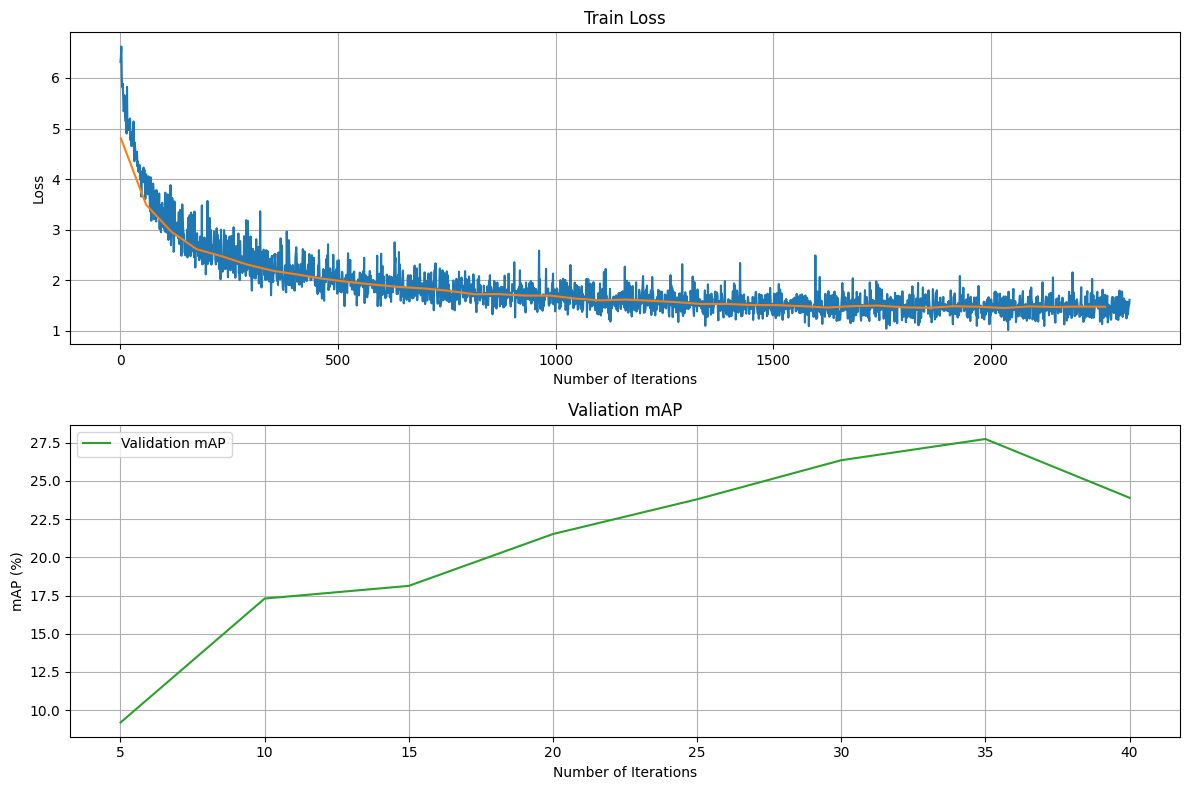

In [46]:
runner.plot_loss(row_figsize=4)

In [47]:
val_metric_40, res_40 = validate(model, test_dataloader, device=DEVICE, score_threshold=0.4, iou_threshold=0.5)
print(f"mAP на тестовом датасете: {val_metric_40:.4}")

Running validation:   0%|          | 0/23 [00:00<?, ?it/s]

mAP на тестовом датасете: 0.2229


In [48]:
res_40

{'map': tensor(0.2229),
 'map_50': tensor(0.5990),
 'map_75': tensor(0.1315),
 'map_small': tensor(0.1648),
 'map_medium': tensor(0.2154),
 'map_large': tensor(0.2563),
 'mar_1': tensor(0.2660),
 'mar_10': tensor(0.3898),
 'mar_100': tensor(0.3921),
 'mar_small': tensor(0.2385),
 'mar_medium': tensor(0.3826),
 'mar_large': tensor(0.4052),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3], dtype=torch.int32)}

Лосс почти не меняется, а метрика уменьшается. Это может говорить о переобучении. Для улучшения качества модели необходимо предпринимать другие меры.